# Pipeline

starting out with sklearn I want to create my own pipeline similar to
  - https://michelleful.github.io/code-blog/2015/06/20/pipelines/
  - http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html
  
 but face some problems. In this sample notebook I formulate 3 Questions. Hopefully you can help me out. 
 
 Thanks a lot.

In [1]:
import pylab as P
%pylab inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


Load  the data.

In [2]:
mydf = pd.DataFrame({'classLabel':[0,0,0,1,1,0,0,0],
                   'categorical':[7,8,9,5,7,5,6,4],
                   'numeric1':[7,8,9,5,7,5,6,4],
                   'numeric2':[7,8,9,5,7,5,6,"N.A"]})
mydf

,categorical,classLabel,numeric1,numeric2
0,7,0,7,7
1,8,0,8,8
2,9,0,9,9
3,5,1,5,5
4,7,1,7,7
5,5,0,5,5
6,6,0,6,6
7,4,0,4,N.A


transform to X, y representation as this is the standard for a pipeline

In [3]:
def transform(data): 
    # Extract the data
    X = data.drop(['classLabel'],  axis=1)
    
    # Extract the labels
    y = data['classLabel']
    
    return X, y

In [4]:
X, y = transform(mydf)

Imports for the real pipeline functions

In [5]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import cross_validation as cv
from sklearn.metrics import make_scorer, cohen_kappa_score

In [6]:
def extractSpecificColumn(X, columns):
    return X[columns]

In [7]:
columnsNumber = ['numeric1']
columnsFactor = ['categorical']

## Question
What is the problem with my functionTransformer?

In case it is disabled it works just fine.

In [8]:
# todo perform featgure extractions in parallel
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('numeric', FunctionTransformer(columnsNumber)),
            ('scale', StandardScaler())
        ]))
    ], n_jobs=1)),
    ('estimator', RandomForestClassifier(n_estimators=50, criterion='entropy', n_jobs=-1))
])

In [9]:
kappaScore = make_scorer(cohen_kappa_score)

manual exploration

In [10]:
split = cv.StratifiedShuffleSplit(y, n_iter=1, test_size=0.2)

In [11]:
for train_index, test_index in split:
    print(train_index)
    print(test_index)
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

[5 7 4 3 1 0]
[2 6]


In [12]:
#model = pipeline.fit(X_train)

In [13]:
# demonstrate that it works
print(X['numeric1'])
X[columnsNumber]

0    7
1    8
2    9
3    5
4    7
5    5
6    6
7    4
Name: numeric1, dtype: int64


,numeric1
0,7
1,8
2,9
3,5
4,7
5,5
6,6
7,4


In [14]:
#y_predicted = model.predict(X_test)

In [15]:
#score

crossvalidation

In [16]:
XoneColumn = X[columnsNumber]
type(XoneColumn)

pandas.core.frame.DataFrame

In [17]:
XoneColumn

,numeric1
0,7
1,8
2,9
3,5
4,7
5,5
6,6
7,4


### Question 3
what is the problem here if I pass `XoneColumn`?

In [18]:
folds = cv.StratifiedShuffleSplit(y, test_size=0.2, n_iter=3)
cv.cross_val_score(pipeline, XoneColumn, y, cv=folds, scoring=kappaScore)

TypeError: 'list' object is not callable

What am I doing wrong / different compared to this approach http://scikit-learn.org/stable/auto_examples/preprocessing/plot_function_transformer.html which is using functionTransformer for the dame purposes?

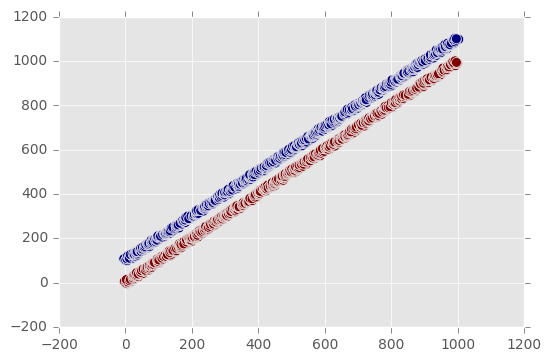

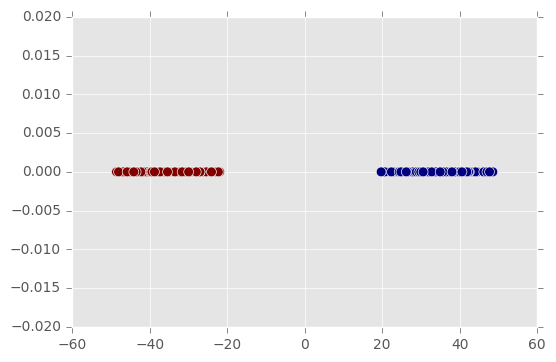

In [19]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer


def _generate_vector(shift=0.5, noise=15):
    return np.arange(1000) + (np.random.rand(1000) - shift) * noise


def generate_dataset():
    """
    This dataset is two lines with a slope ~ 1, where one has
    a y offset of ~100
    """
    return np.vstack((
        np.vstack((
            _generate_vector(),
            _generate_vector() + 100,
        )).T,
        np.vstack((
            _generate_vector(),
            _generate_vector(),
        )).T,
    )), np.hstack((np.zeros(1000), np.ones(1000)))


def all_but_first_column(X):
    return X[:, 1:]


def drop_first_component(X, y):
    """
    Create a pipeline with PCA and the column selector and use it to
    transform the dataset.
    """
    pipeline = make_pipeline(
        PCA(), FunctionTransformer(all_but_first_column),
    )
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    pipeline.fit(X_train, y_train)
    return pipeline.transform(X_test), y_test


if __name__ == '__main__':
    X, y = generate_dataset()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50)
    plt.show()
    X_transformed, y_transformed = drop_first_component(*generate_dataset())
    plt.scatter(
        X_transformed[:, 0],
        np.zeros(len(X_transformed)),
        c=y_transformed,
        s=50,
    )
    plt.show()